In [1]:
%matplotlib inline

import pandas as pd
from sklearn.metrics import auc
import matplotlib.pyplot as plt # standard Python plotting library
import numpy as np  # fundamental package for scientific computing, handles arrays and math
import scipy.signal
from scipy.signal import find_peaks, peak_prominences
import scipy.stats as stats
from scipy.stats import zscore
from pathlib import Path
import tdt # import the tdt library
import seaborn as sns
from matplotlib import rcParams
import os
import numpy as np
import glob

In [2]:
isosbestic = '_415A'
dopa='_465A'
CHANNEL = 1
TRANGE       = [-5, 10]
BASELINE_PER = [-5, 2]
event_type = 'RNP_'
def read_files(path): 
    blockpath = path
    data = tdt.read_block(blockpath, evtype=['epocs','streams'], channel=CHANNEL)
    data = tdt.epoc_filter(data, event_type, t=TRANGE)  #filters the chosen epocs (RNP_) and time set around those epocs
    # More examples of list comprehensions
    min1 = np.min([np.size(x) for x in data['streams'][dopa].filtered])
    min2 = np.min([np.size(x) for x in data['streams'][isosbestic].filtered])
    data['streams'][dopa].filtered = [x[1:min1] for x in data['streams'][dopa].filtered]
    data['streams'][isosbestic].filtered = [x[1:min2] for x in data['streams'][isosbestic].filtered]

    # Downsample and average 10x via a moving window mean
    N = 10 # Average every 10 samples into 1 value
    F415 = []
    F465 = []
    for lst in data['streams'][isosbestic].filtered: 
        small_lst = []
        for i in range(0, min2, N):
            small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
        F415.append(small_lst)

    for lst in data['streams'][dopa].filtered: 
        small_lst = []
        for i in range(0, min1, N):
            small_lst.append(np.mean(lst[i:i+N-1]))
        F465.append(small_lst)

    #Create a mean signal, standard error of signal, and DC offset
    meanF415 = np.mean(F415, axis=0)
    stdF415 = np.std(F415, axis=0)/np.sqrt(len(data['streams'][isosbestic].filtered))
    dcF415 = np.mean(meanF415)
    meanF465 = np.mean(F465, axis=0)
    stdF465 = np.std(F465, axis=0)/np.sqrt(len(data['streams'][dopa].filtered))
    dcF465 = np.mean(meanF465)
    Y_fit_all = []
    Y_dF_all = []
    for x, y in zip(F415, F465):
        x = np.array(x)
        y = np.array(y)
        bls = np.polyfit(x, y, 1)
        fit_line = np.multiply(bls[0], x) + bls[1]
        Y_fit_all.append(fit_line)
        Y_dF_all.append(y-fit_line)
    ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    # Getting the z-score and standard error
    zall = []
    for dF in Y_dF_all: 
        ind = np.where((np.array(ts2)<BASELINE_PER[1]) & (np.array(ts2)>BASELINE_PER[0]))
        zb = np.mean(dF[ind])
        zsd = np.std(dF[ind])
        zall.append((dF - zb)/zsd)
    ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    # ts3 = TRANGE[2] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    
    zerror = np.std(zall, axis=0)#/np.sqrt(np.size(zall, axis=0))

    return zall, ts1, ts2, zerror



In [3]:
h_zavg = [] #het zscore average
h_zste = [] # het zscore standard error
h_ts1 = []
h_ts2 = []
for file in glob.glob(r"N:\2024April_May_Tanks_GRBDA_RI\Day4FR1_04272024\HET/*"): # het
    z_ind = read_files(file)
    h_zavg.extend(z_ind[0])
    h_ts1 = z_ind[1]
    h_ts2 = z_ind[2]
    h_zste.append(z_ind[3])

print(f"total number events: {len(h_zavg)}")

read from t=0s to t=1865.97s
read from t=0s to t=2405.79s
read from t=0s to t=1511.34s
read from t=0s to t=3150.92s
read from t=0s to t=2537.04s
read from t=0s to t=2077.74s


KeyboardInterrupt: 

In [ ]:
len(h_zavg[0])

1018

In [ ]:
auc_list = []
for i in range(len(h_zavg)):
    area = auc(h_ts2,h_zavg[i])
    auc_list.append(area)
auc_list

[0.2576351737260787,
 1.1304485693160753,
 -0.16395579096069168,
 -0.8429023099379123,
 4.802759534621078,
 -0.3216887977364493,
 0.45145973570042,
 -1.463417057969206,
 1.1491573794136272,
 -2.4269654389912074,
 0.19663524230752927,
 1.2098353334571015,
 2.8601597783513064,
 2.6216902526900965,
 2.7210540426889045,
 -1.6262638379001377,
 -0.42978518307605007,
 1.9041484872374668,
 1.1225658284336943,
 -0.5534474523008017,
 1.047127692064037,
 -0.8040115036226798,
 -0.7021049583295759,
 -0.7306588709710817,
 -4.127179453628894,
 1.4074835913510606,
 0.47478770357034733,
 -3.0153358781057564,
 0.10452516954035529,
 1.248821880403813,
 1.8139081942859523,
 0.9603995452054619,
 -0.9232397785139637,
 3.5525046964181675,
 -1.2427496453720557,
 0.5336856424291612,
 1.2503751159921006,
 0.59669997119512,
 2.0102910518206976,
 2.6214584064338986,
 0.11238472063743632,
 2.392232808335152,
 1.5327610521206578,
 -0.4251264233395122,
 0.3412898437082603,
 2.3455772076336685,
 3.3564384870941,
 3.4

In [ ]:
h_zavg

176

In [ ]:
len(h_zavg)

176

In [ ]:
h_zavg_eventwise=(np.array(h_zavg).mean(axis=0))
h_zste_eventwise=np.array(h_zavg).std(axis=0)

print(len(h_zste_eventwise))
auc(h_ts1, h_zavg_eventwise)
# one_event_het_avg = np.mean([h_zavg], axis=0)
# (one_event_het_avg)

1018


0.34487070996888813

In [ ]:
w_zavg = []
w_zste = []
w_ts1 = []
w_ts2 = []
w_ind_z = []
for file in glob.glob(r"N:\2024April_May_Tanks_GRBDA_RI\Day4FR1_04272024\WTY/*"): # wild type
    z_ind = read_files(file)
    w_zavg.extend(z_ind[0])
    w_ts1 = z_ind[1]
    w_ts2 = z_ind[2]
    w_ind_z.append(z_ind[0])
    w_zste.append(z_ind[3])

print(f"total number events: {len(w_zavg)}")

read from t=0s to t=1230.89s
read from t=0s to t=1354.59s
read from t=0s to t=2311.98s
read from t=0s to t=1532.54s
read from t=0s to t=2083.28s
total number events: 146


In [ ]:
len(w_zavg)

146

In [ ]:
w_zavg_eventwise=(np.array(w_zavg).mean(axis=0)) 
w_zste_eventwise=np.array(w_zavg).std(axis=0)
# average hets and wildtypes to one zscore array in a t second period of event
print(auc(w_ts1, w_zavg_eventwise), auc(h_ts1, h_zavg_eventwise))

0.1012633187568231 0.34487070996888813


In [ ]:
# Now try and average per animal

# from collections import defaultdict
# from pathlib import Path
# wt_out = defaultdict(dict)
# het_out = defaultdict(dict)
# # animal_dict = {'files': {
# #                             }
# #                    }
# for file in glob.glob(r"N:\2024April_May_Tanks_GRBDA_RI\Day6_RI30_04292024\WTY/*"): 
#     z_ind = read_files(file)
#     w_zavg = []
#     w_zavg.extend(z_ind[0])
#     w_ts1 = z_ind[1]
#     w_ts2 = z_ind[2]
#     w_zste.append(z_ind[3])
#     wt_out[Path(file).stem]['zscore_average']=w_zavg
#     wt_out[Path(file).stem]['time_range']=w_ts1
#     wt_out[Path(file).stem]['zscore_standard_error']=w_zste

# for file in glob.glob(r"N:\2024April_May_Tanks_GRBDA_RI\Day5_RI30_04282024\HET/*"): 
#    z_ind = read_files(file)
#    h_zavg = []
#    h_zavg.extend(z_ind[0])
#    h_ts1 = z_ind[1]
#    h_ts2 = z_ind[2]
#    h_zste.append(z_ind[3])
#    het_out[Path(file).stem]['zscore_average']=h_zavg
#    het_out[Path(file).stem]['time_range']=h_ts1
#    het_out[Path(file).stem]['zscore_standard_error']=h_zste


In [ ]:
# for file in glob.glob(r"N:\2024April_May_Tanks_GRBDA_RI\Day6_RI30_04292024\HET/*"): 
#     z_ind = read_files(file)
#     h_zavg = []
#     h_zavg.extend(z_ind[0])
#     h_ts1 = z_ind[1]
#     h_ts2 = z_ind[2]
#     h_zste.append(z_ind[3])
#     het_out[Path(file).stem]['zscore_average']=h_zavg
#     het_out[Path(file).stem]['time_range']=h_ts1
#     het_out[Path(file).stem]['zscore_standard_error']=h_zste


In [ ]:
len(h_ts1)

1018

In [ ]:
# for key in wt_out.keys():
#    wt_out[key]['elementwise_sample']=np.array(wt_out[key]['zscore_average']).mean(axis = 0)

# for key in het_out.keys():
#    het_out[key]['elementwise_sample']=np.array(het_out[key]['zscore_average']).mean(axis = 0)

In [ ]:
# wt_out.keys()

In [ ]:
# het_out.keys()

In [ ]:
# het_out['EN71CRFD7-240204-104814']['elementwise_sample']

In [ ]:
# wt_blank_array = []
# for key in wt_out.keys():
#     wt_blank_array.append(wt_out[key]['elementwise_sample'])
# wt_per_animal_whole_avg = np.array(wt_blank_array).mean(axis=0)
# print(auc(w_ts1, wt_per_animal_whole_avg))


In [ ]:
# het_out.keys()
# het_blank_array = []
# for key in het_out.keys():
#     het_blank_array.append(het_out[key]['elementwise_sample'])
# het_per_animal_whole_avg = np.array(het_blank_array).mean(axis=0)
# print(auc(h_ts1, het_per_animal_whole_avg))

In [ ]:
# auc_list_w = []
# ts3 = []
# w_new_z_array = []
# w_cropped_for_auc = []
# for i in range(len(w_ind_z)):
#     w_new_z_array.append(np.mean(w_ind_z[i], axis = 0))

# for i in range(len(w_new_z_array)):
#     w_time_cropped_z = []
#     for j in range(len(ts2)):
#         if (ts2[j] < 2) & (ts2[j] > 0): # start and end time values
#             ts3.append(ts2[j])
#             w_time_cropped_z.append(w_new_z_array[i][j])
#     w_cropped_for_auc.append(w_time_cropped_z)

# print(len(ts3))
# for i in range(len(w_cropped_for_auc)):
#     auc_list_w.append(auc((ts3/(i+1)),w_cropped_for_auc[i]))
# print(auc_list_w)
    
    

In [ ]:
# mean_zste = []
# # mean_zste = np.mean([zste[0],zste[1]], axis = 0)
# for i in range(len(zste[0])):
#     sigma = np.sqrt(((zste[0][i]**2)/len(zste[0]))+((zste[1][i]**2)/len(zste[1])))
#     mean_zste.append(sigma)
# mean_zste
 

In [ ]:
np.array(h_zavg)
h_zerror = np.std(h_zavg, axis=0)/np.sqrt(np.size(h_zavg, axis=0))
np.array(w_zavg)
w_zerror = np.std(w_zavg, axis=0)/np.sqrt(np.size(w_zavg, axis=0))

In [ ]:
# stats.sem(h_zavg)

In [ ]:
from scipy.signal import find_peaks, peak_prominences, peak_widths


In [ ]:
peaks = find_peaks(np.mean(w_zavg, axis=0), prominence=1)
peaks_y = [np.mean(w_zavg, axis=0)[i] for i in peaks[0]]

In [ ]:
w_ts1[589]

0.7999358840012825

In [ ]:
# peaks[0]-widths[2]

In [ ]:
widths = peak_widths(np.mean(w_zavg, axis=0), peaks[0])
widths

(array([90.42007097]),
 array([0.3044302]),
 array([556.59228416]),
 array([647.01235513]))

In [ ]:
prominence = peak_prominences(np.mean(w_zavg, axis=0) ,peaks[0])
prominence # how to do stats if we're calculating the genotype averages

(array([1.53000578]), array([499], dtype=int64), array([711], dtype=int64))

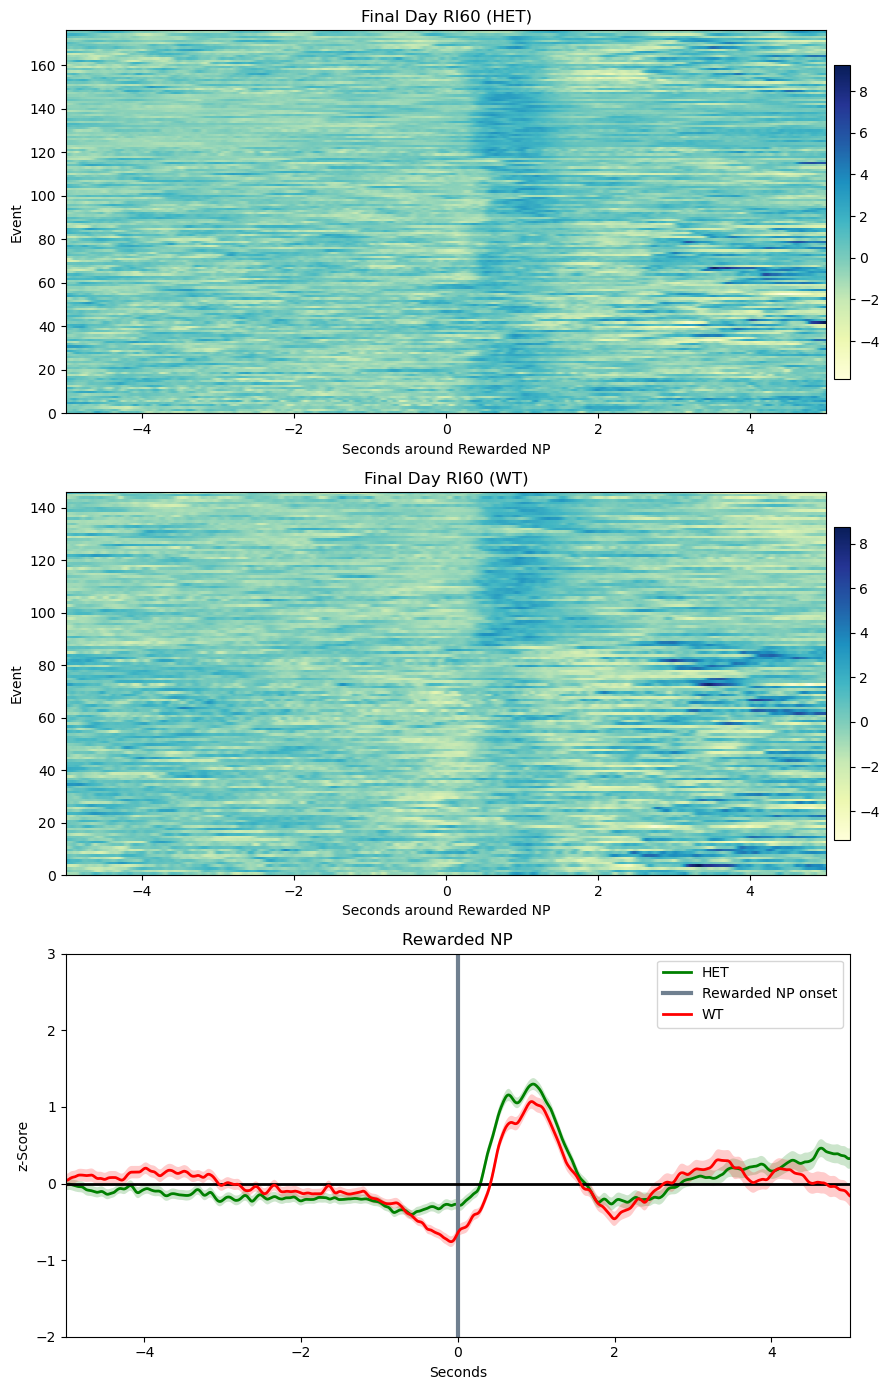

In [ ]:
fig = plt.figure(figsize=(9, 14))
ax1 = fig.add_subplot(311) # Het
cs = ax1.imshow(h_zavg, cmap=plt.cm.YlGnBu, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(h_zavg)])
cbar = fig.colorbar(cs, pad=0.01, fraction=0.02)

ax1.set_title('Final Day RI60 (HET)')
ax1.set_ylabel('Event')
ax1.set_xlabel('Seconds around Rewarded NP')

plt.close() # Suppress figure output again

ax3 = fig.add_subplot(312) # WT
cs3 = ax3.imshow(w_zavg, cmap=plt.cm.YlGnBu, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(w_zavg)])
cbar3 = fig.colorbar(cs3, pad=0.01, fraction=0.02)
ax3.set_title('Final Day RI60 (WT)')
ax3.set_ylabel('Event')
ax3.set_xlabel('Seconds around Rewarded NP')
plt.close()

ax2 = fig.add_subplot(313)
p6 = ax2.plot(h_ts2, np.mean(h_zavg, axis=0), linewidth=2, color='green', label='HET')
p7 = ax2.fill_between(h_ts1, np.mean(h_zavg, axis=0)+h_zerror
                      ,np.mean(h_zavg, axis=0)-h_zerror, facecolor='green', alpha=0.2)

p8 = ax2.axvline(x=0, linewidth=3, color='slategray', label='Rewarded NP onset')
p8 = ax2.axhline(y=0, linewidth=2, color='black')
ax2.set_ylim([-2, 3])
ax2.set_ylabel('z-Score')
ax2.set_xlabel('Seconds')
ax2.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0])
ax2.set_title('Rewarded NP')
# ax2.scatter((peaks[0]-509)/101, peaks_y,s = 60, color="red", marker = "o")
# ax2.scatter(((peaks[0]-509)/101)+(widths[0]/2), peaks_y, s = 60, color = 'blue')
p9 = ax2.plot(w_ts2, np.mean(w_zavg, axis=0), linewidth=2, color='red', label='WT')
p10 = ax2.fill_between(w_ts1, np.mean(w_zavg, axis=0)+w_zerror
                      ,np.mean(w_zavg, axis=0)-w_zerror, facecolor='red', alpha=0.2)

ax2.legend()

plt.close()
fig.tight_layout()
fig
 #Graph 3
#Graph 2

In [ ]:
h_mean_zavg = np.mean(h_zavg, axis=0)
ts4 = []
h_trimmed_z_array = []
w_trimmed_z_array = []
for i in range(len(h_ts2)): # since h_ts and w_ts are the same
    if (h_ts2[i] < 2) & (h_ts2[i] > 0.5): # start and end time values
        ts4.append(h_ts2[i])
        h_trimmed_z_array.append(h_zavg_eventwise[i])
        w_trimmed_z_array.append(w_zavg_eventwise[i])


In [ ]:
print(auc(ts4, h_trimmed_z_array))
print(auc(ts4, w_trimmed_z_array))
# find auc per event and then compare using mann whitney

0.8915501354061498
0.6170382766210267


KstestResult(statistic=0.3333333333333333, pvalue=6.314708059396151e-08, statistic_location=1.046594, statistic_sign=-1)

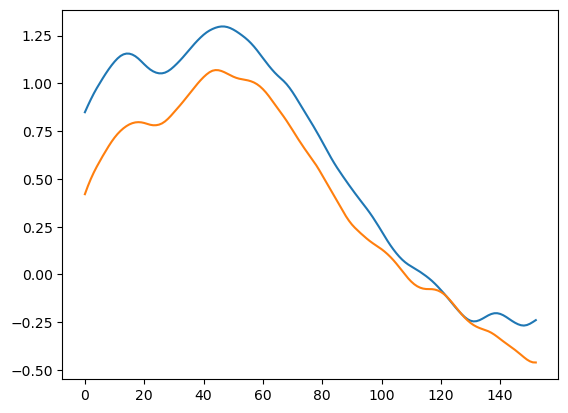

In [ ]:
sns.lineplot(h_trimmed_z_array)
sns.lineplot(w_trimmed_z_array)
scipy.stats.ks_2samp(h_trimmed_z_array,w_trimmed_z_array)
# for stats, use appropriate time block (ie 0-2 s)

In [ ]:
scipy.stats.mannwhitneyu(h_zavg_eventwise,w_zavg_eventwise)

MannwhitneyuResult(statistic=470713.0, pvalue=0.00034700360301871506)

In [ ]:
# spike/slope analysis

Dopamine sensor peak events were calculated using custom peak detection scripts2,49. A 10s moving window was used for thresholding, where high amplitude events (local maxima greater than two median average deviations above the median of the moving window) were removed to calculate a new baseline moving median. Peaks were defined as events with local maxima greater than 3 median average deviations above this new baseline moving median. Peak amplitude was calculated as the difference between the peak maxima and the local median.

In [ ]:
#sliding window
def sliding_window(elements, size):
    if len(elements) <= size:
        return elements
    for i in range(len(elements)- size + 1):
        yield elements[i:i+size]

In [ ]:
x = list(sliding_window(h_trimmed_z_array, 10))

In [ ]:
np.mean(h_zavg_eventwise[0:5])

-0.0096595865

In [ ]:
peaks[0]

array([603], dtype=int64)

In [ ]:
peaks_y # amplitude

[1.0694331]

In [ ]:
(np.mean(w_zavg, axis=0))[613]


1.0186803

In [ ]:
peaks

(array([603], dtype=int64),
 {'prominences': array([1.53000578]),
  'left_bases': array([499], dtype=int64),
  'right_bases': array([711], dtype=int64)})

(array([603], dtype=int64), {'prominences': array([1.53000578]), 'left_bases': array([499], dtype=int64), 'right_bases': array([711], dtype=int64)})
1


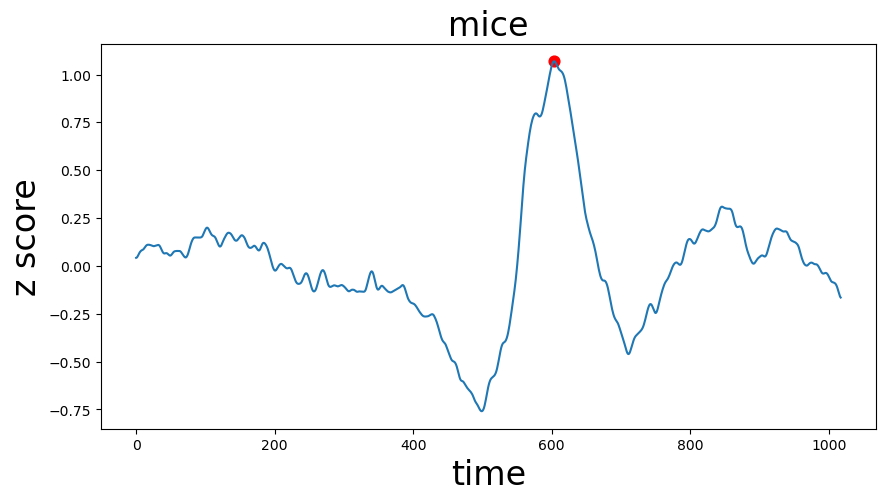

In [ ]:
plt.figure(figsize=[10, 5])
plt.plot((np.mean(w_zavg, axis=0)))
plt.scatter(peaks[0], peaks_y,s = 60, color="red", marker = "o")
plt.title("mice", fontsize=24)
plt.ylabel("z score", fontsize=24)
plt.xlabel("time", fontsize=24)

print(peaks)
print(len(peaks[0]))

In [ ]:
# T50 = widths[0]/(4*(1018/10)) 
# T50
# assumes perfectly symmetrical peak

In [ ]:
T50_list = []
for i in range(len(peaks[0])):
    t50 = (peaks[0][i]-widths[2][i])/(2*101.8)
    T50_list.append(t50)
T50_list
# this is currently per genotype, analyze per event and sav to list in "epoch_averaging.ipynb"

[0.22793573596110517]